# cArtGAN

Este modelo se encarga de hacer un GAN condicional desde cero con los datos

# Librerias

In [2]:
#from helpers import load_data # la función fue creada por nostros, para más info ver el notebook de data.ipynb
import matplotlib.pyplot as plt
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from tensorflow.keras.models import Model, load_model # for assembling a Neural Network model
from tensorflow.keras.layers import Input, Dense, Embedding, Reshape, Concatenate, Flatten, Dropout # for adding layers
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, ReLU, LeakyReLU # for adding layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model # for plotting model diagram
from tensorflow.keras.optimizers import Adam # for model optimization 
import numpy as np
import os
from PIL import Image
import h5py

Tensorflow/Keras: 2.11.0


# Cargar datos

In [206]:
filepath = "data/data_art.h5"
with h5py.File(filepath, "r") as f:
    data = np.array(f["data"])
    labels = np.array(f["labels"])
data = (data - 127.5) / 127.5
labels = labels.reshape((15000, 1))
# shuffle
idxs = np.random.permutation(len(data))
data = data[idxs].astype("float32")
labels = labels[idxs]

In [196]:
def load_real_samples():
    # load cifar10 dataset
    (trainX, labels), (_, _) = cifar10.load_data()
    # convert from unsigned ints to floats
    X = trainX.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X, labels
data, labels = load_real_samples()

# GENERATOR

In [3]:
def generator(latent_dim, in_shape=(4,4,1), n_cats=3):
    # TODO: cambiar inshape a 8x8x1
    # Label Inputs
    in_label = Input(shape=(1,), name='Generator-Label-Input-Layer') # Input Layer
    lbls = Embedding(input_dim = n_cats, output_dim = 50,
                     name='Generator-Label-Embedding-Layer')(in_label) # Embed label to vector
    
    # Generator Inputs (latent vector)
    in_latent = Input(shape=latent_dim, name='Generator-Latent-Input-Layer')
    # Scale up to image dimensions
    n_nodes = in_shape[0] * in_shape[1] 
    lbls = Dense(n_nodes, name='Generator-Label-Dense-Layer')(lbls)
    lbls = Reshape((in_shape[0], in_shape[1], 1), name='Generator-Label-Reshape-Layer')(lbls) # New shape

    # Generator Inputs (latent vector)
    in_latent = Input(shape=latent_dim, name='Generator-Latent-Input-Layer')
    
    # Image Foundation 
    n_nodes = in_shape[0] * in_shape[1] * 256 
    g = Dense(n_nodes, name='Generator-Foundation-Layer')(in_latent)
    g = ReLU(name='Generator-Foundation-Layer-Activation-1')(g)
    g = Reshape((in_shape[0], in_shape[1], 256), name='Generator-Foundation-Layer-Reshape-1')(g)
    
    # Combine both inputs so it has two channels
    concat = Concatenate(name='Generator-Combine-Layer')([g, lbls])

    # Hidden Layer 1
    g = Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-1')(concat)
    g = LeakyReLU(alpha=0.2, name='Generator-Hidden-Layer-Activation-1')(g)
    
    # Hidden Layer 2
    g = Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-2')(g)
    g = LeakyReLU(alpha=0.2, name='Generator-Hidden-Layer-Activation-2')(g)
    
    # Hidden Layer 3
    g = Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-3')(g)
    g = LeakyReLU(alpha=0.2, name='Generator-Hidden-Layer-Activation-3')(g)
    
    # Hidden Layer 4
    #g = Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-4')(g)
    #g = LeakyReLU(alpha=0.2, name='Generator-Hidden-Layer-Activation-4')(g)
    
    # Output Layer (Note, we use only one filter because we have a greysclae image. Color image would have three
    output_layer = Conv2D(filters=3, kernel_size=(7,7), activation='tanh', padding='same', name='Generator-Output-Layer')(g)
    # TODO: cambiar filters a 3
    # Define model
    model = Model([in_latent, in_label], output_layer, name='Generator')
    return model

# Instantiate
latent_dim=100 # Our latent space has 100 dimensions. We can change it to any number
gen_model = generator(latent_dim)

# Show model summary and plot model diagram
gen_model.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Generator-Latent-Input-Layer (  [(None, 100)]       0           []                               
 InputLayer)                                                                                      
                                                                                                  
 Generator-Label-Input-Layer (I  [(None, 1)]         0           []                               
 nputLayer)                                                                                       
                                                                                                  
 Generator-Foundation-Layer (De  (None, 4096)        413696      ['Generator-Latent-Input-Layer[0]
 nse)                                                            [0]']                    

# DISCRIMINATOR

In [201]:
def discriminator(in_shape=(32,32,3), n_cats=3):
    # TODO: cambiar in_shape a 128x128x3
    # Label Inputs
    in_label = Input(shape=(1,), name='Discriminator-Label-Input-Layer') # Input Layer
    lbls = Embedding(n_cats, 50, name='Discriminator-Label-Embedding-Layer')(in_label) # Embed label to vector
    
    # Scale up to image dimensions
    n_nodes = in_shape[0] * in_shape[1] 
    lbls = Dense(n_nodes, name='Discriminator-Label-Dense-Layer')(lbls)
    lbls = Reshape((in_shape[0], in_shape[1], 1), name='Discriminator-Label-Reshape-Layer')(lbls) # New shape

    # Image Inputs
    in_image = Input(shape=in_shape, name='Discriminator-Image-Input-Layer')
    
    # Combine both inputs so it has two channels
    concat = Concatenate(name='Discriminator-Combine-Layer')([in_image, lbls])

    # Hidden Layer 1
    h = Conv2D(filters=64, kernel_size=(3,3), padding='same', name='Discriminator-Hidden-Layer-1')(concat)
    h = LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-1')(h)
    
    # Hidden Layer 2
    h = Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', name='Discriminator-Hidden-Layer-2')(h)
    h = LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-2')(h)
    #h = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid', name='Discriminator-MaxPool-Layer-2')(h) # Max Pool

    # Hidden Layer 3
    h = Conv2D(filters=256, kernel_size=(3,3), strides=(2,2), padding='same', name="Discriminator-Hidden-Layer-3")(h)
    h = LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-3')(h)
    h = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid', name='Discriminator-MaxPool-Layer-2')(h) # Max Pool

    # Flatten and Output Layers
    h = Flatten(name='Discriminator-Flatten-Layer')(h) # Flatten the shape
    h = Dropout(0.2, name='Discriminator-Flatten-Layer-Dropout')(h) # Randomly drop some connections for better generalization
   
    output_layer = Dense(1, activation='sigmoid', name='Discriminator-Output-Layer')(h) # Output Layer
    
    # Define model
    model = Model([in_image, in_label], output_layer, name='Discriminator')
    
    # Compile the model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# Instantiate
dis_model = discriminator()
dis_model.summary()

Model: "Discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Discriminator-Label-Input-Layer [(None, 1)]          0                                            
__________________________________________________________________________________________________
Discriminator-Label-Embedding-L (None, 1, 50)        150         Discriminator-Label-Input-Layer[0
__________________________________________________________________________________________________
Discriminator-Label-Dense-Layer (None, 1, 1024)      52224       Discriminator-Label-Embedding-Lay
__________________________________________________________________________________________________
Discriminator-Image-Input-Layer [(None, 32, 32, 3)]  0                                            
______________________________________________________________________________________

# CGAN

In [202]:
def def_gan(generator, discriminator):
    
    # We don't want to train the weights of discriminator at this stage. Hence, make it not trainable
    discriminator.trainable = False
    
    # Get Generator inputs / outputs
    gen_latent, gen_label = generator.input # Latent and label inputs from the generator
    gen_output = generator.output # Generator output image
    
    # Connect image and label from the generator to use as input into the discriminator
    gan_output = discriminator([gen_output, gen_label])
    
    # Define GAN model
    model = Model([gen_latent, gen_label], gan_output, name="cDCGAN")
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model

# Instantiate
gan_model = def_gan(gen_model, dis_model)

# Show model summary and plot model diagram
gan_model.summary()

Model: "cDCGAN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Generator-Latent-Input-Layer (I [(None, 100)]        0                                            
__________________________________________________________________________________________________
Generator-Label-Input-Layer (In [(None, 1)]          0                                            
__________________________________________________________________________________________________
Generator-Foundation-Layer (Den (None, 4096)         413696      Generator-Latent-Input-Layer[0][0
__________________________________________________________________________________________________
Generator-Label-Embedding-Layer (None, 1, 50)        150         Generator-Label-Input-Layer[0][0]
_____________________________________________________________________________________________

In [6]:
def real_samples(dataset, categories, n):
    # Create a random list of indices
    indx = np.random.randint(0, dataset.shape[0], n)
    
    # Select real data samples (images and category labels) using the list of random indeces from above
    X, cat_labels = dataset[indx], categories[indx]

    # Class labels
    y = np.ones((n, 1))
    return [X, cat_labels], y
    
def latent_vector(latent_dim, n, n_cats=3):
    
    # Generate points in the latent space
    latent_input = np.random.randn(latent_dim * n)
    
    # Reshape into a batch of inputs for the network
    latent_input = latent_input.reshape(n, latent_dim)
    
    # Generate category labels 
    cat_labels = np.random.randint(0, n_cats, n)
    return [latent_input, cat_labels] 
  

def fake_samples(generator, latent_dim, n):
    
    # Draw latent variables
    latent_output, cat_labels = latent_vector(latent_dim, n)
    
    # Predict outputs (i.e., generate fake samples)
    X = generator.predict([latent_output, cat_labels])
    
    # Create class labels
    y = np.zeros((n, 1))
    return [X, cat_labels], y

def show_fakes(generator, latent_dim, n=10):
    
    # Get fake (generated) samples
    x_fake, y_fake = fake_samples(generator, latent_dim, n)
    
    # Rescale from [-1, 1] to [0, 1]
    X_tst = (x_fake[0] + 1) / 2.0
    
    # Display fake (generated) images
    fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
    k=0
    for i in range(0,2):
        for j in range(0,5):
            axs[i,j].matshow(((X_tst[k]+1)/2))
            axs[i,j].set(title=x_fake[1][k])
            axs[i,j].axis('off')
            k=k+1
    plt.show()

# Entrenamiento


In [210]:
def train(g_model, d_model, gan_model, dataset, categories, latent_dim, n_epochs=10, n_batch=128, n_eval=200):
    # Number of batches to use per each epoch
    checkpoint_path = "checkpoints_scratch32/cp-{epoch:04d}.ckpt"
    batch_per_epoch = int(dataset.shape[0] / n_batch)
    print(' batch_per_epoch: ',  batch_per_epoch)
    # Our batch to train the discriminator will consist of half real images and half fake (generated) images
    half_batch = int(n_batch / 2)
    
    # We will manually enumare epochs 
    for i in range(n_epochs):
        
        # Enumerate batches over the training set
        for j in range(batch_per_epoch):
    
        # Discriminator training
            # Prep real samples
            [x_real, cat_labels_real], y_real = real_samples(dataset, categories, half_batch)
            # Train discriminator with real samples
            discriminator_loss1, _ = d_model.train_on_batch([x_real, cat_labels_real], y_real)
            
            # Prep fake (generated) samples
            [x_fake, cat_labels_fake], y_fake = fake_samples(g_model, latent_dim, half_batch)
            # Train discriminator with fake samples
            discriminator_loss2, _ = d_model.train_on_batch([x_fake, cat_labels_fake], y_fake)


        # Generator training
            # Get values from the latent space to be used as inputs for the generator
            [latent_input, cat_labels] = latent_vector(latent_dim, n_batch)
            # While we are generating fake samples, 
            # we want GAN generator model to create examples that resemble the real ones,
            # hence we want to pass labels corresponding to real samples, i.e. y=1, not 0.
            y_gan = np.ones((n_batch, 1))

            # Train the generator via a composite GAN model
            generator_loss = gan_model.train_on_batch([latent_input, cat_labels], y_gan)
        
        # Summarize training progress and loss
        if (i+1) % 10 == 0:
            print('Epoch: %d, Batch: %d/%d, D_Loss_Real=%.3f, D_Loss_Fake=%.3f Gen_Loss=%.3f' % 
                  (i+1, j+1, batch_per_epoch, discriminator_loss1, discriminator_loss2, generator_loss))
            show_fakes(g_model, latent_dim)
            gen_model.save_weights(checkpoint_path.format(epoch=i+1))

 batch_per_epoch:  117
Epoch: 10, Batch: 117/117, D_Loss_Real=0.334, D_Loss_Fake=0.479 Gen_Loss=1.379


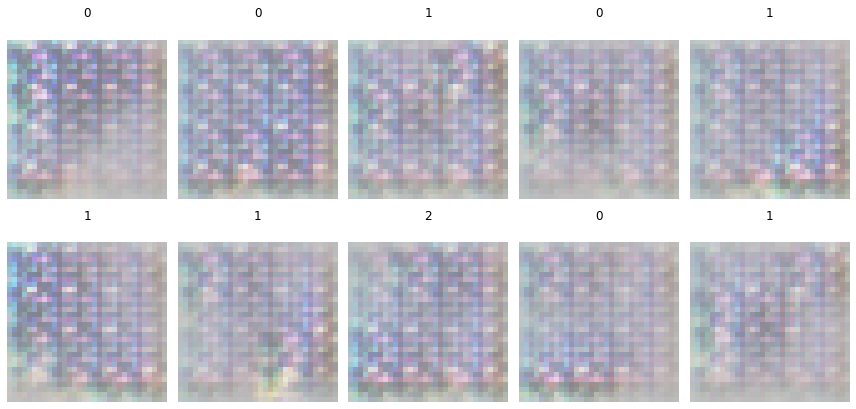

Epoch: 20, Batch: 117/117, D_Loss_Real=0.540, D_Loss_Fake=0.445 Gen_Loss=1.603


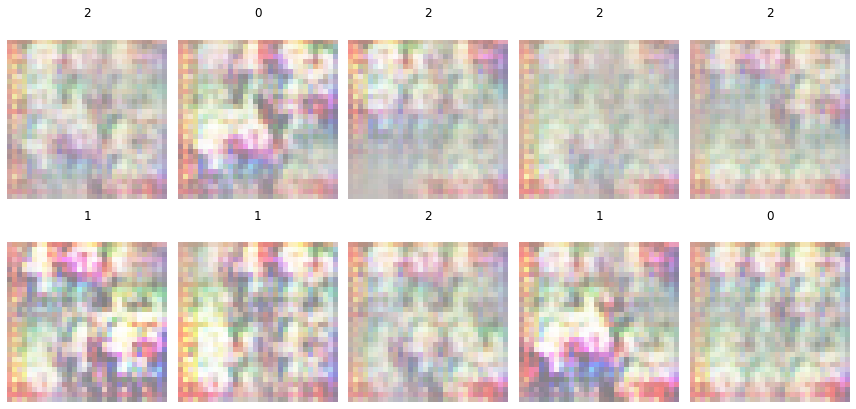

Epoch: 30, Batch: 117/117, D_Loss_Real=0.659, D_Loss_Fake=0.364 Gen_Loss=1.861


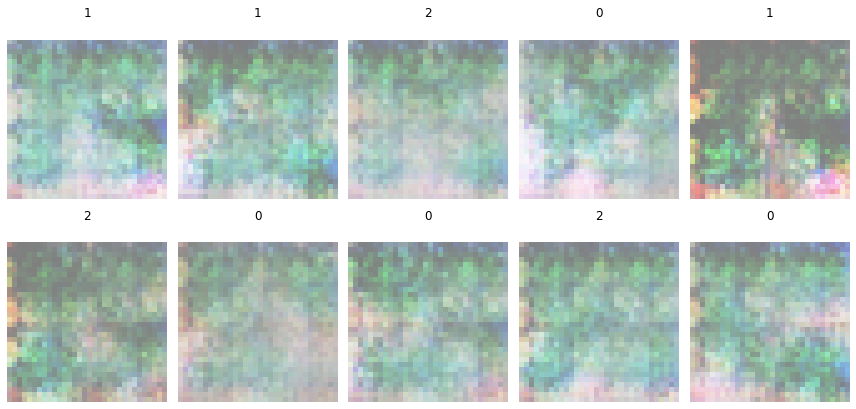

Epoch: 40, Batch: 117/117, D_Loss_Real=0.743, D_Loss_Fake=0.581 Gen_Loss=1.451


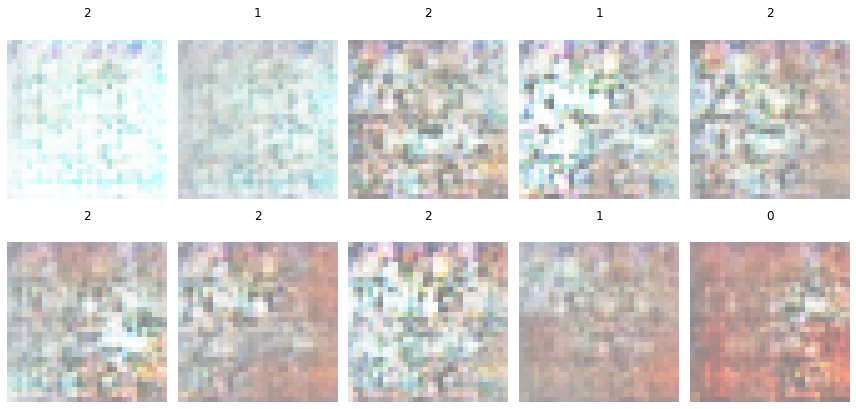

Epoch: 50, Batch: 117/117, D_Loss_Real=0.583, D_Loss_Fake=0.644 Gen_Loss=1.175


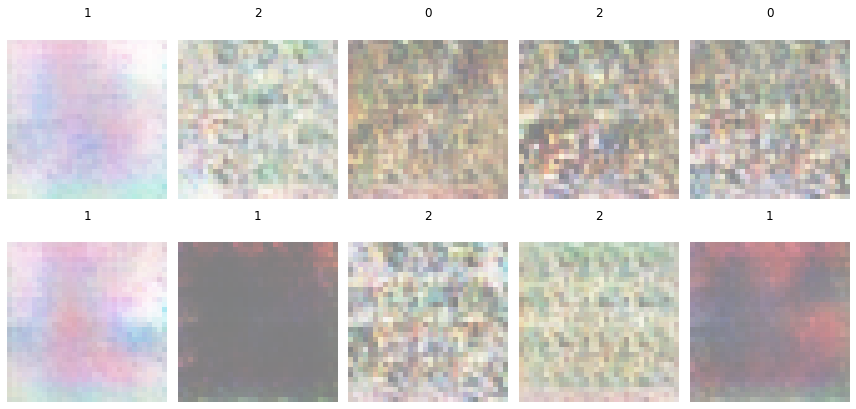

Epoch: 60, Batch: 117/117, D_Loss_Real=0.564, D_Loss_Fake=0.533 Gen_Loss=1.267


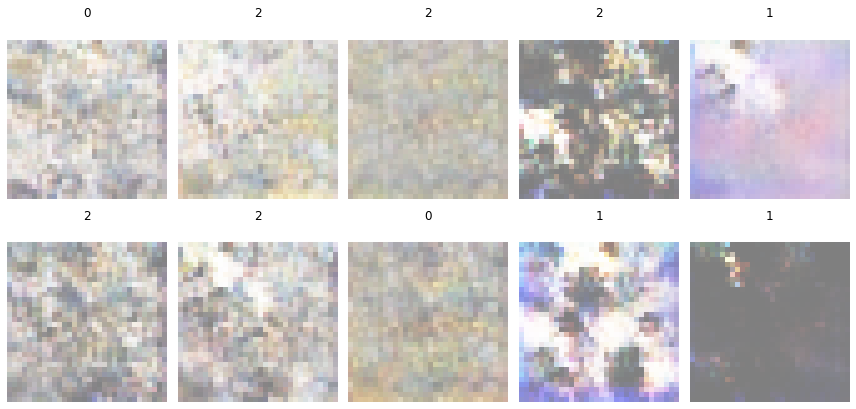

Epoch: 70, Batch: 117/117, D_Loss_Real=0.577, D_Loss_Fake=0.609 Gen_Loss=1.262


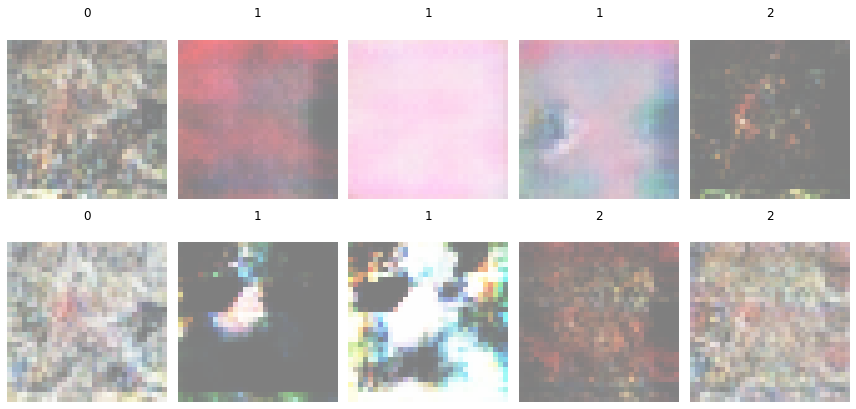

Epoch: 80, Batch: 117/117, D_Loss_Real=0.445, D_Loss_Fake=0.440 Gen_Loss=1.400


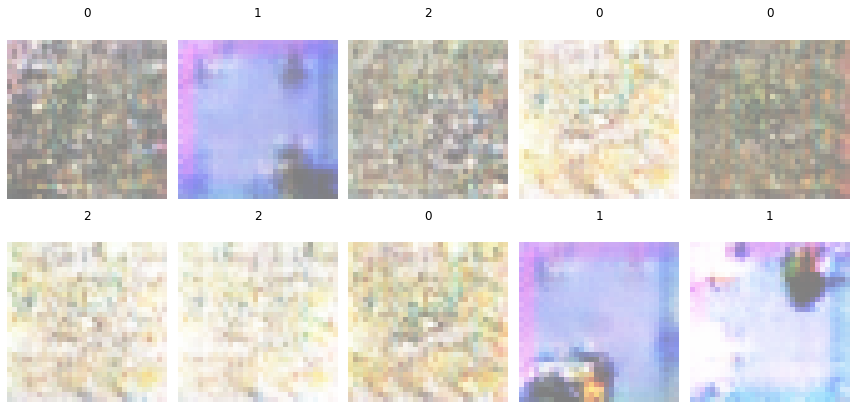

Epoch: 90, Batch: 117/117, D_Loss_Real=0.455, D_Loss_Fake=0.483 Gen_Loss=1.584


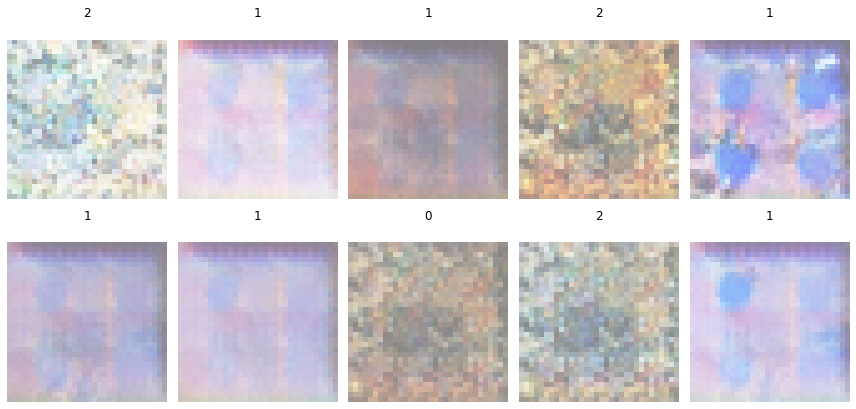

Epoch: 100, Batch: 117/117, D_Loss_Real=0.593, D_Loss_Fake=0.434 Gen_Loss=1.547


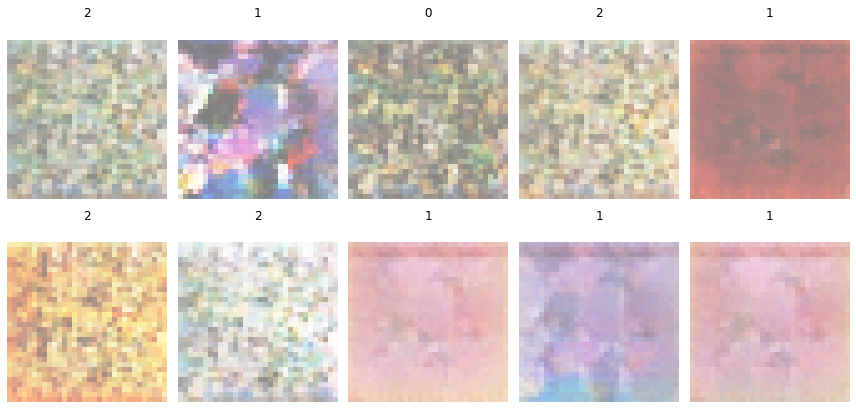

In [211]:
train(gen_model, dis_model, gan_model, data, labels, latent_dim, n_epochs=100)

# CARGAR MODELO

In [1]:
from tensorflow import train
checkpoint_dir = "checkpoints/checkpoints_scratch32"

latest = train.latest_checkpoint(checkpoint_dir)

In [4]:
model = generator(latent_dim=100)
model.load_weights(latest)

1/1 [==============================] - 0s 300ms/step


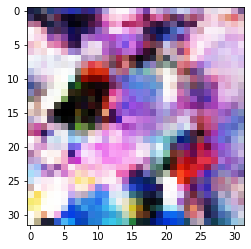

In [7]:
latent_points, _ = latent_vector(100, 1)
# Generate images
img  = model.predict([latent_points, np.array([1])])
img = (img + 1) / 2.0
plt.imshow(img[0])